# Partial Differential Equations - Stefan problem

## Introduction

In this project we will consider a one dimensional Stefan Problem with different types of boundary conditions. It is a model that describes the heat transfer and phase change phenomena occurring at the interface (a boundary moving in time) between a solid and a liquid during melting or solidification process. The Stefan problem can be used in various fields, most common being metallurgy and modelling the melting of glaciers and ice sheets. It allows to understand and predict the behaviour of the solid-liquid interface over time. A few analytical solutions to the problem are known, although it is far more common to solve it numerically. In this project, we will use Crank-Nicholson scheme to solve it with three different boundary conditions for a region that initially has zero thickness, and we will compare two of our solutions with exisiting exact solutions.

## Historical background

The problem of heat diffusion in a medium with change between liquid and solid phase was first examined in 1831 by two french mathematicians, Gabriel Lamé and Benoît Paul Émile Clapeyron. They tried to determine the thickness of solid, obtained by cooling the liquid in the halfspace $x>0$, with a constant boundary condition at $x=0$, and stated that it is proportional to the square root of time.
In 1860, the German physicist and mathematician Franz Ernst Neumann found an exact solution to ice formulation in polar sees.
In 1889, the Austrian physicist and mathematician Joseph Stefan examined the moving boundary problems more thoroughly and published four papers on mathematical models describing the physical problems with phase change, one of them using the Neumann’s solution. Since that time, the moving-boundary problems are called Stefan problems.[[2](#bibliography)]

## Applications
<br>

<li> Constant boundary condition – that condition can be used to model the situations where the material is heat up by a heat source of constant temperature, like thawing of soil in a constant-temperature environment. 
<br><br> 
<li> Exponential boundary condition – here we observe an exponential increase of medium temperature; using this condition, we can study the heat transfer in melting metals.
<br><br>
    
<li> Sinusoidal boundary condition – in this case the temperature at the boundary follows a sinusoidal variation in time, so the system experiences periodic heating and cooling cycles. It can be used to model the melting of glaciers or ice sheets.

## Mathematical formulation of the problem

Mathematically speaking, the Stefan problem is a heat equation with a boundary-moving domain (often called a “free boundary problem” or a “moving boundary problem”).[[2](#bibliography)]

$$\begin{equation}
    U_t = \alpha_L U_{xx}, \\
    U_t = \alpha_S U_{xx},
    \label{eq1}
    \tag{1}
\end{equation}$$

where $\alpha_L, \alpha_S$ &mdash; thermal diffusivity $\left[\frac{m^2}{s}\right]$ for liquid and solid, respectively. 

However, an assumption can be made that the slab is intially at its freezing temperature and because of that, only one phase is considered as active. From that we obtain a one-phase Stefan problem for temperature distribution and location of the interface:[[3](#bibliography)] 

$$\begin{equation}
    U_t = \alpha_L U_{xx}, \quad 0 < x < s(t), \quad t > 0,
    \label{eq2}
    \tag{2}
\end{equation}$$

with initial conditions

$$\begin{equation}
    s(0) = 0,
    \label{eq3}
    \tag{3}
\end{equation}$$

$$\begin{equation}
    U(x, 0) = 0,
    \label{eq4}
    \tag{4}
\end{equation}$$

and boundary conditions at $x = 0$ and at $x = s(t)$. For $x = 0$, we will consider three different boundary conditions: [[1](#bibliography)]

$$\begin{equation}
    U(0, t) = 1,
    \label{eq5}
    \tag{5}
\end{equation}$$

$$\begin{equation}
    U(0, t) = e^t - 1,
    \label{eq6}
    \tag{6}
\end{equation}$$

$$\begin{equation}
    U(0, t) = 1 - \epsilon \sin(\omega t),
    \label{eq7}
    \tag{7}
\end{equation}$$

where $\epsilon$ &mdash; amplitude, and $\omega$ &mdash; frequency of thermal oscillation. For the $x=s(t)$, we have

$$\begin{equation}
    U(s(t), t) = 0,
    \label{eq8}
    \tag{8}
\end{equation}$$

$$\begin{equation}
    \beta s' = -U_x \bigg|_{x=s(t)},
    \label{eq9}
    \tag{9}
\end{equation}$$

where $\beta$ &mdash; reciprocal of the Stefan number (definition of the Stefan number can be found in [[4](#bibliography)]). As we can see, the location of the interface is not known beforehand, and therefore must be determined as part of the solution.

For boundary conditions $\eqref{eq5}$ and $\eqref{eq6}$, an exact analytical solutions can be found, although with the latter it is only valid for $\beta=1$. The solution for $\eqref{eq5}$ is following

$$\begin{equation}
    U(x, t) = \frac{1 - \text{erf}\left(\frac{x}{2\sqrt{t}}\right)}{\text{erf}(\alpha)},
    \label{eq10}
    \tag{10}
\end{equation}$$

$$\begin{equation}
    s(t) = 2\alpha \sqrt{t},
    \label{eq11}
    \tag{11}
\end{equation}$$

where $\alpha$ satisfies

$$\begin{equation}
    \sqrt{\pi} \beta \alpha \text{erf}(\alpha) e^{\alpha^2} = 1.
    \label{eq12}
    \tag{12}
\end{equation}$$

The solution for $\eqref{eq6}$ and $\beta=1$:

$$\begin{equation}
    U(x, t) = e^{t-x} - 1.
    \label{eq13}
    \tag{13}
\end{equation}$$

$$\begin{equation}
    s(t) = t.
    \label{eq14}
    \tag{14}
\end{equation}$$

<br>

## Derivation of initial conditions

To derive the initial conditions, we will follow the procedure showed in [[1](#bibliography)].
We will use self-similar solutions to all boundary conditions at $t \rightarrow 0$ in order to introduce the initial conditions for temperature. In order to do that, we will use transformed coordinates in the form

$$\begin{equation}
    \xi = \frac{x}{s(t)}, \quad U = h(t)F(\xi, t).
    \label{eq15}
    \tag{15}
\end{equation}$$

With the newly introduced coordinates, the equations $\eqref{eq2}$, $\eqref{eq8}$ and $\eqref{eq9}$ take the form

$$\begin{equation}
    hF_{\xi \xi} = s \left(sh'F + shF_t - \xi s'hF_{\xi}\right),
    \label{eq16}
    \tag{16}
\end{equation}$$

$$\begin{equation}
    F(1, t) = 0,
    \label{eq17}
    \tag{17}
\end{equation}$$

$$\begin{equation}
    \beta ss' = -hF_{\xi}\bigg|_{\xi=1},
    \label{eq18}
    \tag{18}
\end{equation}$$

And the boundary conditions become

$$\begin{equation}
    F(0, t) = \frac{1}{h},
    \label{eq19}
    \tag{19}
\end{equation}$$

$$\begin{equation}
    F(0, t) = \frac{e^t - 1}{h},
    \label{eq20}
    \tag{20}
\end{equation}$$

$$\begin{equation}
    F(0, t) = \frac{1 - \epsilon \sin(\omega t)}{h}.
    \label{eq21}
    \tag{21}
\end{equation}$$

Let us start with deriving the initial condition for $\eqref{eq19}$. In this case, we need to assume $h(t) = 1$ to ensure that $F(0, t)$ does not depend on time. Moreover, we set $s(t) = 2\alpha \sqrt{t}$ and we obtain 

$$\begin{equation}
    F_{\xi \xi} = -2\alpha^2 \xi F_{\xi},
    \label{eq22}
    \tag{22}
\end{equation}$$

$$\begin{equation}
    F(1) = 0, \quad F(0) = 1, \quad 2\alpha^2 \beta = -F_{\xi} \bigg|_{\xi=1}.
    \label{eq23}
    \tag{23}
\end{equation}$$

As $t \rightarrow 0$, the solution to above equation has solution

$$\begin{equation}
    F(\xi) = 1 - \frac{\text{erf($\alpha \xi$)}}{\text{erf($\alpha$)}}.
    \label{eq24}
    \tag{24}
\end{equation}$$

Same choice of $h(t)$ and $s(t)$ applies to $\eqref{eq21}$, resulting in the same initial condition. Now, we will derive the initial condition for $\eqref{eq20}$. Here, the choice is $h(t) = t$ and $s(t) = \lambda t$ for strictly positive $\lambda$. From that we obtain 

$$\begin{equation}
    F_{\xi \xi} = 0,
    \label{eq25}
    \tag{25}
\end{equation}$$

$$\begin{equation}
    F(1) = 0, \quad F(0) = 1, \quad \beta \lambda^2 = -F_{\xi} \bigg|_{\xi=1},
    \label{eq26}
    \tag{26}
\end{equation}$$

which leads to solution

$$\begin{equation}
    F(\xi) = 1 - \xi, \quad \lambda = \frac{1}{\sqrt{\beta}}.
    \label{eq27}
    \tag{27}
\end{equation}$$

<br>

## Crank–Nicolson method

Crank–Nicolson scheme, described in [[7](#bibliography)], is a type of finite difference method. As it's a numerical method we approximate the solution on a given interval. We deal with a function dependent on time and space so we have to specify the interval for both variables and also the grid that we will use to perform the Crank-Nicolson scheme. Here we take $\xi \in [0, 1]$ and $t \in [0, T]$ with $\Delta t = k$ and $\Delta \xi = h$. As an example we will use the Stefan problem for constant boundary conditions described in equation $\eqref{eq19}$. 

To be able to use Crank-Nicolson scheme we also need to introduce the respective forward and backward difference quotients for time and space

$$
\begin{equation}
\partial_t F_{j}^{n} = \frac{F_{j}^{n+1} - F_{j}^{n}}{k} \text{,} \quad \tilde{\partial_t} F_{j}^{n} = \frac{F_{j}^{n} - F_{j}^{n-1}}{k}\text{,}
\end{equation}
\tag{28}\label{eq:cn1}
$$
$$
\begin{equation}
\partial_{\xi} F_{j}^{n} = \frac{F_{j+1}^{n} - F_{j}^{n}}{h} \text{,} \quad \tilde{\partial_{\xi}} F_{j}^{n} = \frac{F_{j}^{n} - F_{j-1}^{n}}{h} \text{.}
\end{equation}
\tag{28}\label{eq:cn2}
$$

We consider the case of constant boundary condition, so we can put $h(t) = 1$ to equation $\eqref{eq16}$ and substitute $z\equiv s^2$ as it will simplify calculations in this case. Therefore
$$
\begin{equation}
\frac{\partial^2 F}{\partial \xi^2} = z \frac{\partial F}{\partial t} - \frac{\xi}{2} \frac{d z}{d t} \frac{\partial F}{\partial \xi}
\end{equation}
\tag{29}\label{eq:cn3}
$$

This equation can be rewritten using the difference quotients defined earlier. We also have to define the step, as the boundary conditions are not time dependent in this case we only need the spatial step $z_{n+\frac{1}{2}} = \frac{z_{n+1}+z_n}{2}$. Thus

$$
\begin{equation}
\begin{split}
& \frac{1}{2} \left(\frac{F_{j+1}^{n+1} - 2 F_{j}^{n+1} + F_{j-1}^{n+1}}{h^2}\right) + \frac{1}{2} \left(\frac{F_{j+1}^{n} - 2 F_{j}^{n} + F_{j-1}^{n}}{h^2}\right) = \\
& = z_{n+\frac{1}{2}} \left(\frac{F_{j}^{n+1} - F_{j}^{n}}{k}\right) - \frac{\xi_j}{2} \frac{z_{n+1}-z_n}{k} \left[\frac{1}{2}\left(\frac{F_{j+1}^{n+1} - F_{j-1}^{n+1}}{2h}\right) + \frac{1}{2}\left(\frac{F_{j+1}^{n} - F_{j-1}^{n}}{2h}\right)\right]
\end{split}
\end{equation}
\tag{30}\label{eq:cn4}
$$

From that we can easily rearrange it to be able to calculate $F^{n+1}$ using $F^{n}$. To simplify we define $z' = \frac{z_{n+1}-z_n}{k}$ and we get

$$
\begin{equation}
\begin{split}
& \frac{1}{2h^2} \left(F_{j+1}^{n+1} - 2 F_{j}^{n+1} + F_{j-1}^{n+1}\right) + - \frac{\xi_j z'}{8h} \left(F_{j+1}^{n+1} - F_{j-1}^{n+1}\right) - \frac{z_{n+\frac{1}{2}}}{k} F_{j}^{n+1} = \\
& = -\frac{1}{2h^2}\left(F_{j+1}^{n} - 2 F_{j}^{n} + F_{j-1}^{n}\right) - \frac{\xi_j z'}{8h}\left(F_{j+1}^{n} - F_{j-1}^{n}\right) - \frac{z_{n+\frac{1}{2}}}{k} F_{j}^{n}
\end{split}
\end{equation}
\tag{31}\label{eq:cn5}
$$

With $F_{0}^{n+1} = 1$ from boundary condition. Additionally, again using difference quotients, from equation $\eqref{eq18}$ we obtain

$$
\begin{equation}
\frac{\beta}{2} \left(\frac{z_{n+1}-z_n}{k}\right) = -\frac{1}{2}\left(\frac{F_{M+1}^{n+1} - F_{M-1}^{n+1}}{2h}\right) -\frac{1}{2}\left(\frac{F_{M+1}^{n} - F_{M-1}^{n}}{2h}\right)
\end{equation}
\tag{32}\label{eq:cn6}
$$

Now putting this equation to $\eqref{eq:cn5}$ evaluated at $j=M$ we get the quadratic equation for $z_{n+1}$
$$
\begin{equation}
\frac{\beta \xi_M}{2k} \left(z_{n+1}^2\right) + \left(\frac{\beta \xi_M}{k} z_n + \frac{2\beta r}{v} + F_M^{n+1} - F_M^{n}\right)z_{n+1} + \frac{\beta \xi_M}{2k}\left(z_{n}^2\right) - \frac{\beta r}{v}\left(z_{n}\right) + \left(2r + z_n\right) \left(F_M^{n+1} + F_M^{n}\right) - 2r \left(F_{M-1}^{n+1} + F_{M-1}^{n}\right)
\end{equation}
\tag{33}\label{eq:cn7}
$$


Additionally, in each step of Crank-Nicholson scheme, we will compute the current value of $s(t)$, using the Newton-Raphson method, described in [[6](#bibliography)]. Similarly we can do it for other two types of boundary conditions, but then we also have to similarily discretize the step in time as $t_{n+\frac{1}{2}} = \frac{t_{n+1}+t_{n}}{2}$. Then by performing similar calculations with $h(t) = t$ we can obtain formulas for other boundary conditions. 

<br>

## Order of accuracy

To determine the method's order of accuracy, first we need to compute the errors for a fixed time $t_n$. To do this, we will start by introducing a sequence $\Delta \xi_k$

$$\begin{equation}
    \Delta \xi_k = 2^{-k} \Delta \xi_0, \quad k = 0, 1, 2, \ldots, \quad \Delta \xi_0 = 0.1,
    \tag{33}
    \label{eq33}
\end{equation}$$

and the mesh

$$\begin{equation}
    \xi_{i, k} = i \Delta \xi_{k}, \quad i = 0, 1, \ldots, M_k,
    \tag{34}
    \label{eq34}
\end{equation}$$

where 

$$\begin{equation}
    M_k = 2^k M_0, \quad M_0 = 10.
    \tag{35}
    \label{eq35}
\end{equation}$$

With that we define the sequence of errors

$$\begin{equation}
    E_k^n = \left(\Delta \xi_k  \sum_{i=0}^{M_0}(F(\xi_{i,0}, t_n) - F_{2^k i}^n)^2 \right)
    \tag{36}
    \label{eq36}
\end{equation}$$

Once we calculate the errors, we can find the order of accuracy in space using the formula below [[1](#bibliography)]

$$\begin{equation}
    p = \frac{\ln\left(\frac{E_k^n}{E_{k+1}^n}\right)}{\ln\left( \frac{\Delta \xi_k^n}{\Delta \xi_{k+1}^n}\right)} = \frac{\ln\left(\frac{E_k^n}{E_{k+1}^n}\right)}{\ln 2}. 
    \tag{37}
    \label{eq37}
\end{equation}$$

The other way to check the order of accuracy is to compute the errors, draw the log-log plot of errors against $\Delta \xi_k$, and find the slope of obtained linear function, which we will also do to double-check the result. We will follow analogous procedure to derive the order of accuarcy in time.

### Constant boundary condition

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import math
from sympy import *

In [2]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 150
style.use("seaborn")

In [3]:
def gen_matrixA(M):
    A = np.zeros((M-1, M-1))
    for i in range(M-1):
        A[i][i] = -2
        if 1 <= i < M-1:
            A[i-1][i] = 1
        if 0 <= i < M-2:
            A[i+1][i] = 1
    return A

def gen_matrixB(xs):
    M = len(xs)
    B = np.zeros((M, M))
    for i in range(M):
        if 1 <= i < M:
            B[i-1][i] = xs[i-1]
        if 0 <= i < M-1:
            B[i+1][i] = -xs[i+1]
    return B

def quadratic(x, a, b, c):
    return a*x*x + b*x + c

def quadratic_prim(x, h, a, b, c):
    return (quadratic(x+h, a, b, c) \
            - quadratic(x, a, b, c)) / h

def newton_rhapson(x, h, a, b, c, epsilon):
    step = 0
    while step < 10**6:
        new_x = x - quadratic(x, a, b, c) \
        / quadratic_prim(x, h, a, b, c)
        new_x = abs(new_x)
        q = quadratic(new_x, a, b, c)
        if abs(q) < epsilon:
            return new_x
        x = new_x
        step += 1
    return x

In [9]:
def finite_difference_method(t_max, dt, beta=1, M=10):
    N = t_max + 1
    ksi = np.linspace(0, 1, M+1)
    dx = ksi[1] - ksi[0]
    s = [0, 0]
    r = dt/(dx*dx)
    v = dt/dx
    
    x = symbols('x')
    alpha = nsolve(np.sqrt(np.pi)*beta*x*erf(x)*exp(x**2) - 1, x, 1)
    
    A = 1/(2*dx**2)*gen_matrixA(M+1)
    B = 1/(8*dx)*gen_matrixB(ksi[1:])
    I = np.identity(M)
    
    f = np.zeros(len(ksi))
    for j in range(len(ksi)):
        f[j] = 1 - (math.erf(alpha*ksi[j])/math.erf(alpha))
    
    result = np.zeros((N, M+1))
    result[0] = f
    st = np.zeros(N)
    old_f = f[1:]
    
    a = beta*ksi[M]/(2*dt)
    
    for i in range(1, N):
        s_error = 10**(-4)
        while s_error > 10**(-8):
            sn_12 = (s[1] + s[0])/2
            sp = (s[1] - s[0])/dt

            L = A - (sn_12/dt)*I + sp*B
            R = -(sn_12/dt)*I - sp*B - A
            D = np.zeros(M)
            D[0] = 1/(2*dx*dx) - sp/(8*dx)*ksi[1]

            new_f = np.linalg.inv(L) @ (R @ old_f - 2*D)

            b = -(beta*ksi[M]/dt)*s[0] + 2*beta*r/v + new_f[M-1] - old_f[M-1]
            c = beta*ksi[M]/(2*dt)*s[0]*s[0] - 2*beta*r/v*s[0] + (2*r + s[0])*new_f[M-1] + \
                (2*r - s[0])*old_f[M-1] - 2*r*(new_f[M-2] + old_f[M-2])
            s_old = s[1]
            s_new = newton_rhapson(s[1], 10**(-6), a, b, c, 10**(-6))
            s[1] = s_new
            s_error = abs(s_new - s_old)

        s = [s_new, s_new]
        st[i] = s_new
        f[0] = 1
        f[1:] = new_f
        f[-1] = 0
        result[i] = f
        old_f = new_f
    return result, np.sqrt(st)

In [5]:
def ana_soli(t_max, dt, beta, M = 10):
    x = symbols('x')
    alpha = nsolve(np.sqrt(np.pi)*beta*x*erf(x)*exp(x**2) - 1, x, 1)
    ts = np.arange(0, t_max+dt, 1)*dt
    ksi = np.linspace(0, 1, M+1)
    U_ana = [0]*len(ts)
    U_ana[0] = np.zeros(M)
    s_ana = 2*alpha*np.sqrt(ts)
    for i in range(1, len(ts)):
        U = np.zeros(len(ksi))
        for j in range(len(ksi)):
            U[j] = 1 - (math.erf(alpha*ksi[j])/math.erf(alpha))
        U_ana[i] = U
    return U_ana, s_ana

### $\beta = 2$

In [111]:
t = 10
dt = 0.01
beta = 2
M1 = 10
M2 = 10

In [112]:
fdm0 = finite_difference_method(t, dt, beta, M1)
ana0 = ana_soli(t, dt, beta, M2)

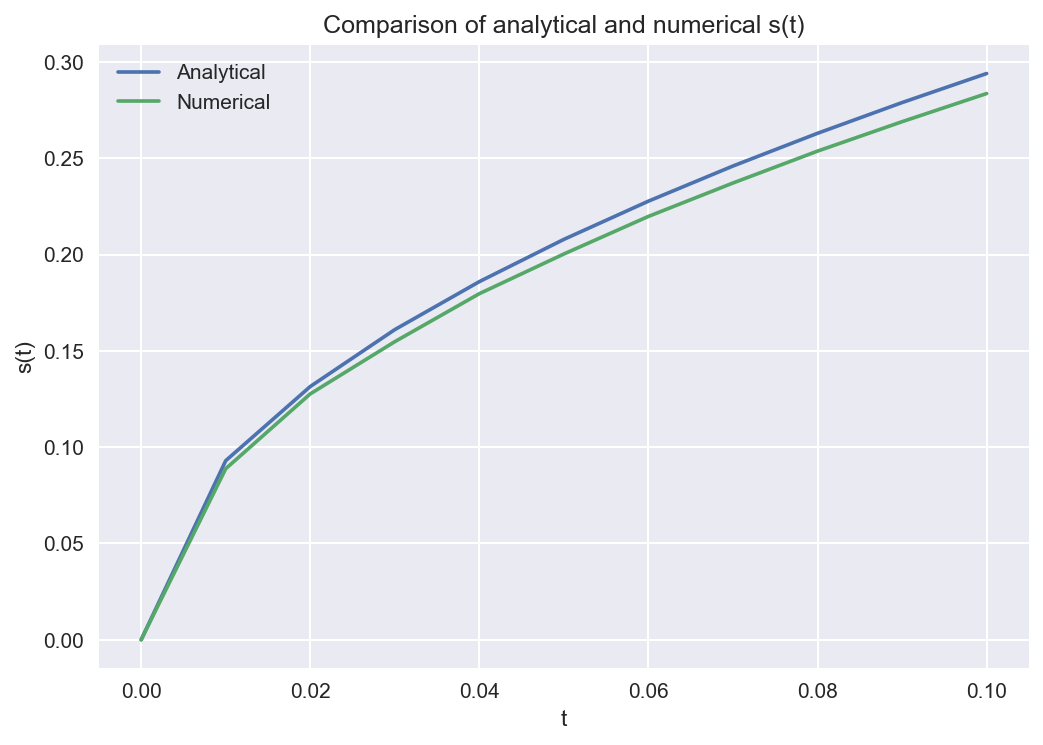

In [113]:
ts = np.arange(0, t+dt, 1)*dt
plt.plot(ts, ana0[1])
plt.plot(ts, fdm0[1])
plt.legend(["Analytical", "Numerical"])
plt.xlabel("t")
plt.ylabel("s(t)")
plt.title("Comparison of analytical and numerical s(t)")
plt.show()

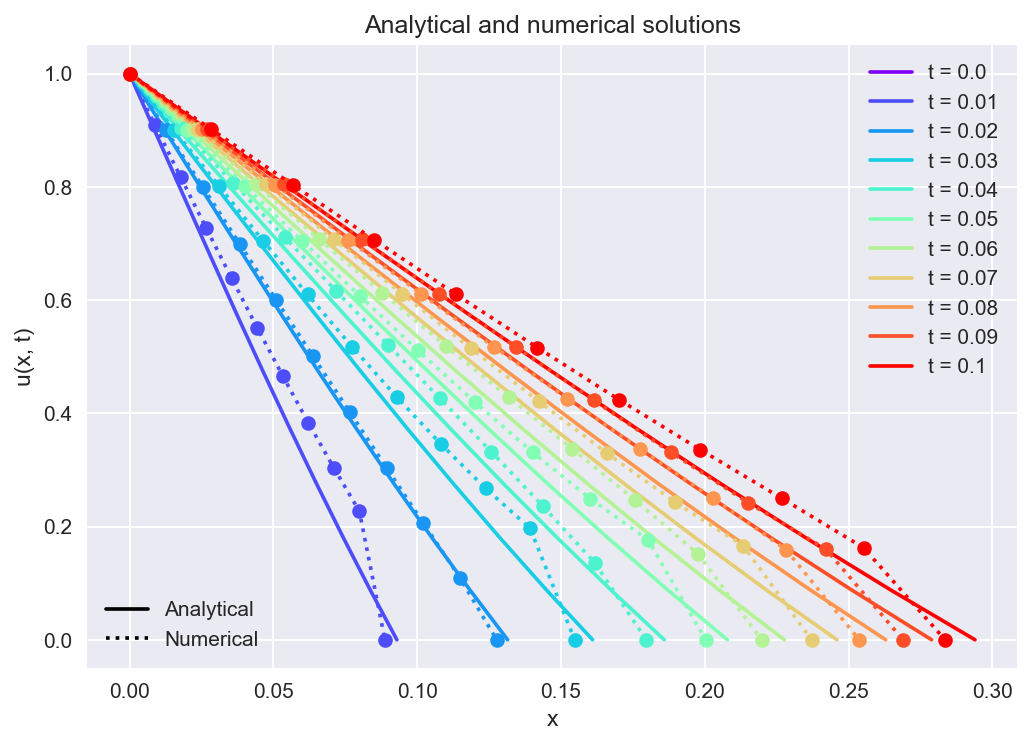

In [114]:
ksi2 = np.linspace(0, 1, M2 + 1)
ksi1 = np.linspace(0, 1, M1 + 1)
fig, ax = plt.subplots()
styles = ['-', 'dotted']
style_names = ['Analytical', 'Numerical']
ts = np.arange(0, t+dt, 1)*dt
colors = plt.cm.rainbow(np.linspace(0, 1, len(ts))) 

for i in range(1, len(ana0[0])):
    ax.plot(ksi2*ana0[1][i], ana0[0][i], ls=styles[0], c=colors[i])
for i in range(1, len(fdm0[0])):
    ax.plot(ksi1*fdm0[1][i], fdm0[0][i], ls=styles[1], c=colors[i], marker='o')

for cc, col in enumerate(colors):
    ax.plot(np.NaN, np.NaN, c=colors[cc], label=f"t = {ts[cc]}")

ax2 = ax.twinx()
for ss, sty in enumerate(styles):
    ax2.plot(np.NaN, np.NaN, ls=styles[ss],
             label=style_names[ss], c='black')
ax2.get_yaxis().set_visible(False)
ax.legend(loc=1)
ax2.legend(loc=3)
ax.set_xlabel("x")
ax.set_ylabel("u(x, t)")
plt.title("Analytical and numerical solutions")
plt.show()

### $\beta = 0.5$

In [115]:
t = 10
dt = 0.01
beta = 0.5
M1 = 10
M2 = 10

In [116]:
fdm = finite_difference_method(t, dt, beta, M1)
ana = ana_soli(t, dt, beta, M2)

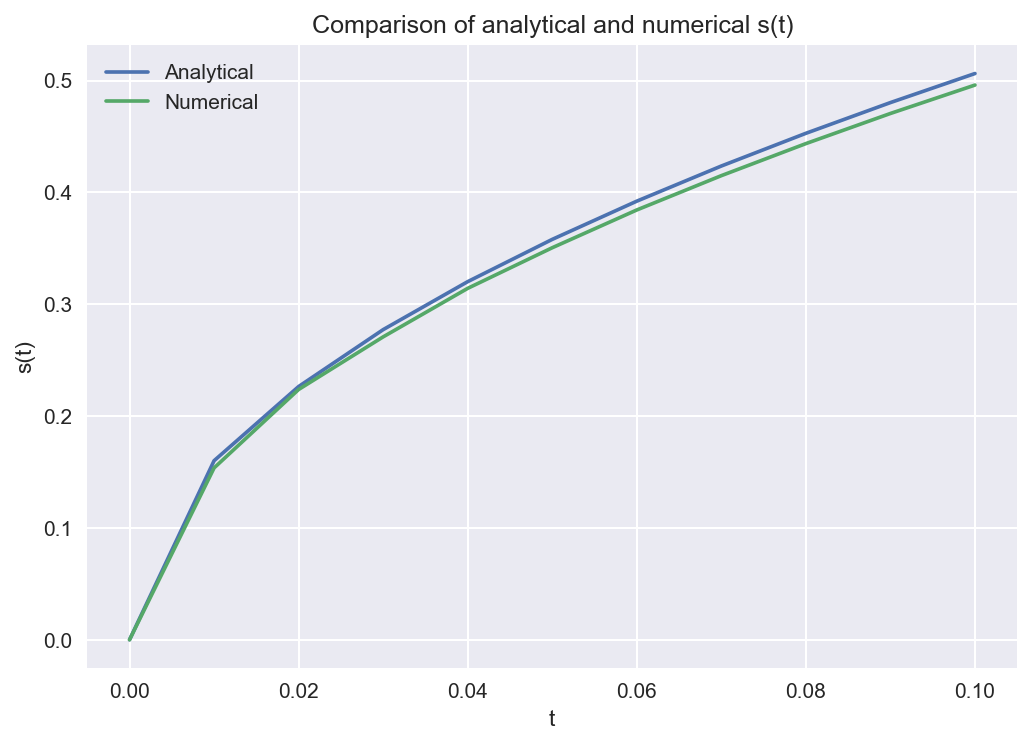

In [117]:
ts = np.arange(0, t+dt, 1)*dt
plt.plot(ts, ana[1])
plt.plot(ts, fdm[1])
plt.legend(["Analytical", "Numerical"])
plt.xlabel("t")
plt.ylabel("s(t)")
plt.title("Comparison of analytical and numerical s(t)")
plt.show()

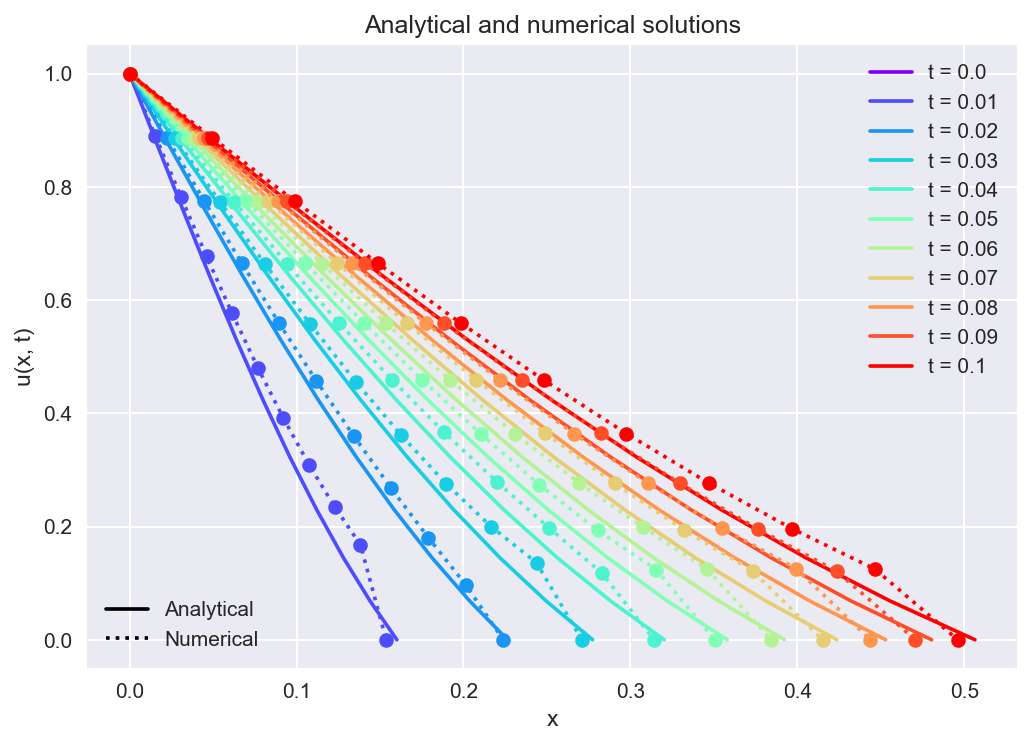

In [118]:
ksi2 = np.linspace(0, 1, M2 + 1)
ksi1 = np.linspace(0, 1, M1 + 1)
fig, ax = plt.subplots()
styles = ['-', 'dotted']
style_names = ['Analytical', 'Numerical']
ts = np.arange(0, t+dt, 1)*dt
colors = plt.cm.rainbow(np.linspace(0, 1, len(ts))) 

for i in range(1, len(ana[0])):
    ax.plot(ksi2*ana[1][i], ana[0][i], ls=styles[0], c=colors[i])
for i in range(1, len(fdm[0])):
    ax.plot(ksi1*fdm[1][i], fdm[0][i], ls=styles[1], c=colors[i], marker='o')

for cc, col in enumerate(colors):
    ax.plot(np.NaN, np.NaN, c=colors[cc], label=f"t = {ts[cc]}")

ax2 = ax.twinx()
for ss, sty in enumerate(styles):
    ax2.plot(np.NaN, np.NaN, ls=styles[ss],
             label=style_names[ss], c='black')
ax2.get_yaxis().set_visible(False)
ax.legend(loc=1)
ax2.legend(loc=3)
ax.set_xlabel("x")
ax.set_ylabel("u(x, t)")
plt.title("Analytical and numerical solutions")
plt.show()

### Time dependent exponential boundary condition

In this case we will only consider $\beta = 1$, as we want to compare our results to the exact solution.

In [119]:
def quartic(x, t, F_new, F_old, M, beta, dt, dx, ksi, s):
    r = dt/dx**2
    v = dt/dx
    return (2*r*(t[1]+t[0])*(F_new[M-1]+F_old[M-1]))-(4*beta/v)*(r+((ksi[M]/(4*dx))*(x**2-s[0]**2)))*(x**2-s[0]**2)

def quartic_prim(x, h, t, F_new, F_old, M, beta, dt, dx, ksi, s):
    return (quartic(x+h, t, F_new, F_old, M, beta, dt, dx, ksi, s) \
            - quartic(x, t, F_new, F_old, M, beta, dt, dx, ksi, s)) / h

def newton_rhapson2(x, h, t, F_new, F_old, M, beta, dt, dx, ksi, epsilon, s):
    step = 0
    while step < 10**6:
        new_x = x - quartic(x, t, F_new, F_old, M, beta, dt, dx, ksi, s) \
        / quartic_prim(x, h, t, F_new, F_old, M, beta, dt, dx, ksi, s)
        new_x = abs(new_x)
        #if abs(x - new_x) < epsilon:
        q = quartic(new_x, t, F_new, F_old, M, beta, dt, dx, ksi, s)
        if abs(q) < epsilon:
            return new_x
        x = new_x
        step += 1
    return x

def finite_difference_method2(t_max, dt, beta=1, M=10):
    ts = np.arange(0, t_max+dt, 1)*dt
    N = len(ts)
    ksi = np.linspace(0, 1, M+1)
    dx = ksi[1] - ksi[0]
    gamma = 1/np.sqrt(beta)
    s = [0, 0]

    A = 1/(2*dx**2)*gen_matrixA(M+1)
    B = 1/(4*dx)*gen_matrixB(ksi[1:])
    I = np.identity(M)
    
    f = 1 - ksi
    
    result = np.zeros((N, M+1))
    result[0] = f
    st = np.zeros(N)
    old_f = f[1:]
    
    for i in range(1, N):
        s_error = 10**(-4)
        while s_error > 10**(-15):
            tn_12 = (ts[i]+ts[i-1])/2
            sn_12 = (s[1] + s[0])/2
            sp = (s[1] - s[0])/dt

            L = tn_12*A - sn_12**2 * (0.5 + tn_12/dt)*I + tn_12*sn_12*sp*B
            R = -tn_12*A + sn_12**2 * (0.5 - tn_12/dt)*I - tn_12*sn_12*sp*B
            D = np.zeros(M)
            if i == 1:
                D[0] = -(tn_12/(2*dx**2) + (ksi[1]*tn_12*sn_12*(s[1]-s[0])/dt)/(4*dx))*((np.exp(ts[i])-1)/ts[i] + 1)
            else:
                D[0] = -(tn_12/(2*dx**2) + (ksi[1]*tn_12*sn_12*(s[1]-s[0])/dt)/(4*dx))*((np.exp(ts[i])-1)/ts[i] \
                                                                                       + (np.exp(ts[i-1])-1)/(ts[i-1]))
            new_f = np.linalg.inv(L) @ (R @ old_f + D)
            s_old = s[1]
            s_new = newton_rhapson2(s[1], 10**(-6), [ts[i],ts[i-1]], new_f, old_f, M, beta, dt, dx, ksi, 10**(-6), s)
            s[1] = s_new
            s_error = abs(s_new - s_old)
            
        s = [s_new, s_new]
        st[i] = s_new
        f[0] = (np.exp(ts[i])-1)/ts[i] + (np.exp(ts[i-1])-1)/(ts[i-1]) - f[0] if i > 1 else 1
        f[1:] = new_f
        f[-1] = 0
        U = f*ts[i]
        result[i] = U
        old_f = new_f
    return result, st

In [120]:
def ana_solii(t_max, dt, beta, M = 10):
    ts = np.arange(0, t_max+dt, 1)*dt
    ksi = np.linspace(0, 1, M+1)
    gamma = 1/np.sqrt(beta)
    s_ana = np.zeros(len(ts))
    U_ana = [0]*len(ts)
    for i in range(1, len(ts)):
        s_ana[i] = gamma*ts[i]
        U_ana[i] = np.exp(ts[i] - s_ana[i] * ksi) - 1
    return U_ana, s_ana

### $\beta = 1$

In [121]:
t = 10
dt = 0.01
beta = 1
M1 = 10
M2 = 10

In [122]:
ana2 = ana_solii(t, dt, beta, M2)

In [123]:
fdm2 = finite_difference_method2(t, dt, beta, M1)

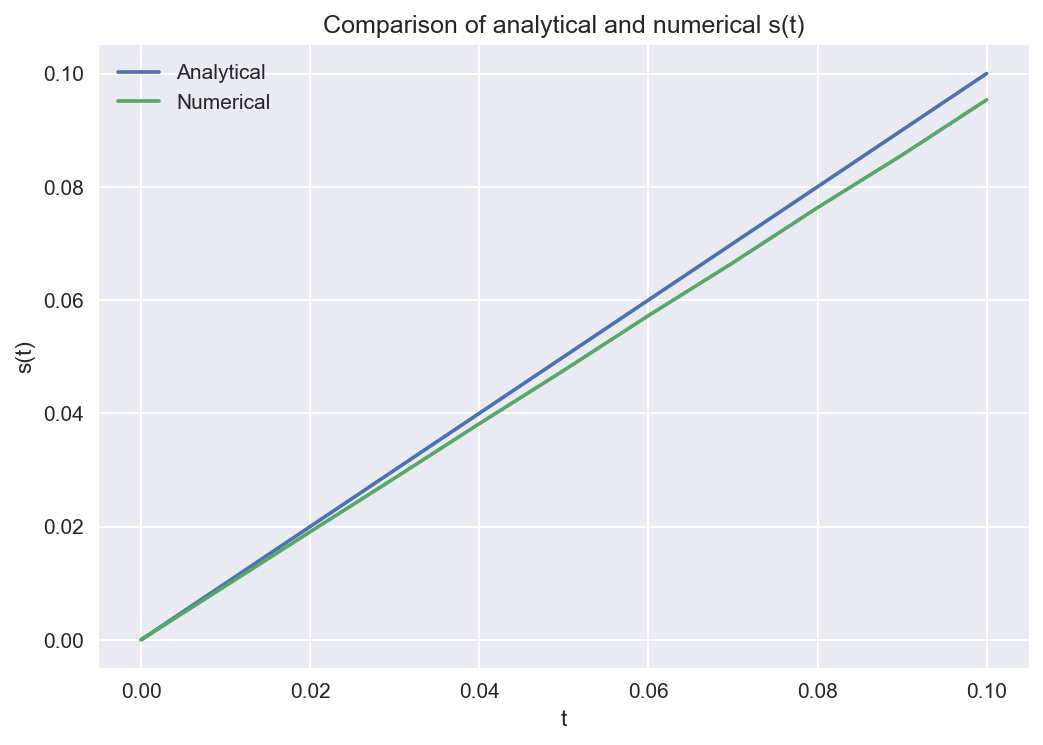

In [124]:
ts = np.arange(0, t+dt, 1)*dt
plt.plot(ts, ana2[1])
plt.plot(ts, fdm2[1])
plt.legend(["Analytical", "Numerical"])
plt.xlabel("t")
plt.ylabel("s(t)")
plt.title("Comparison of analytical and numerical s(t)")
plt.show()

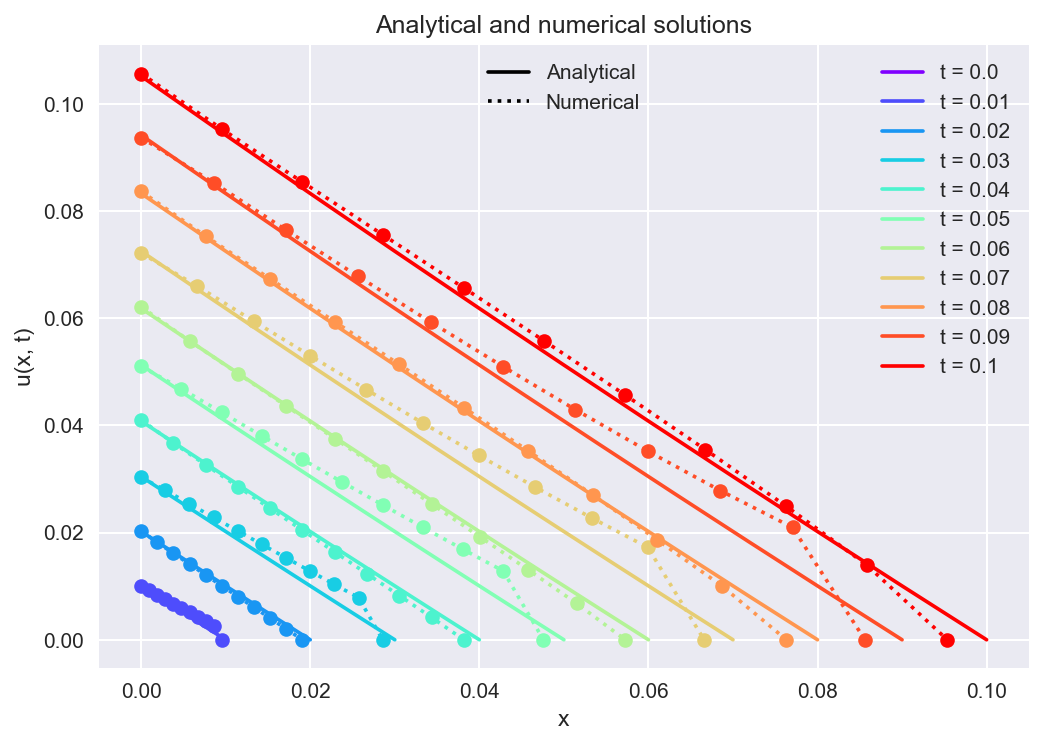

In [125]:
ksi2 = np.linspace(0, 1, M2 + 1)
ksi1 = np.linspace(0, 1, M1 + 1)
fig, ax = plt.subplots()
styles = ['-', 'dotted']
style_names = ['Analytical', 'Numerical']
ts = np.arange(0, t+dt, 1)*dt
colors = plt.cm.rainbow(np.linspace(0, 1, len(ts))) 

for i in range(1, len(ana2[0])):
    ax.plot(ksi2*ana2[1][i], ana2[0][i], ls=styles[0], c=colors[i])
for i in range(1, len(fdm2[0])):
    ax.plot(ksi1*fdm2[1][i], fdm2[0][i], ls=styles[1], c=colors[i], marker='o')

for cc, col in enumerate(colors):
    ax.plot(np.NaN, np.NaN, c=colors[cc], label=f"t = {ts[cc]}")

ax2 = ax.twinx()
for ss, sty in enumerate(styles):
    ax2.plot(np.NaN, np.NaN, ls=styles[ss],
             label=style_names[ss], c='black')
ax2.get_yaxis().set_visible(False)
ax.legend(loc=1)
ax2.legend(loc='upper center')
ax.set_xlabel("x")
ax.set_ylabel("u(x, t)")
plt.title("Analytical and numerical solutions")
plt.show()

#### Time dependent periodic boundary condition

In [68]:
def finite_difference_method3(t_max, dt, beta=1, M=10, epsilon=0.5, omega=np.pi/2):
    ts = np.arange(0, t_max+dt, 1)*dt
    N = len(ts)
    ksi = np.linspace(0, 1, M+1)
    dx = ksi[1] - ksi[0]
    s = [0, 0]
    r = dt/(dx*dx)
    v = dt/dx
    
    x = symbols('x')
    alpha = nsolve(np.sqrt(np.pi)*beta*x*erf(x)*exp(x**2) - 1, x, 1)
    
    A = 1/(2*dx**2)*gen_matrixA(M+1)
    B = 1/(4*dx)*gen_matrixB(ksi[1:])
    I = np.identity(M)
    
    f = np.zeros(len(ksi))
    for j in range(len(ksi)):
        f[j] = 1 - (math.erf(alpha*ksi[j])/math.erf(alpha))
    
    result = np.zeros((N, M+1))
    result[0] = f
    st = np.zeros(N)
    old_f = f[1:]
    
    a = beta*ksi[M]/(2*dt)
    
    for i in range(1, N):

        sn_12 = (s[1] + s[0])/2
        sp = (s[1] - s[0])/dt
        tn_12 = (ts[i]+ts[i-1])/2

        L = tn_12*A - sn_12**2 * (0.5 + tn_12/dt)*I + tn_12*sn_12*sp*B
        R = -tn_12*A + sn_12**2 * (0.5 - tn_12/dt)*I - tn_12*sn_12*sp*B
        D = np.zeros(M)

        D[0] = -(tn_12/(2*dx**2) + (ksi[1]*tn_12*sn_12*(s[1]-s[0])/dt)/(4*dx))*(1 - epsilon*np.sin(omega*ts[i]) \
                                                                               + 1 - epsilon*np.sin(omega*ts[i-1]))
        new_f = np.linalg.inv(L) @ (R @ old_f + D)

        b = -(beta*ksi[M]/dt)*s[0] + 2*beta*r/v + new_f[M-1] - old_f[M-1]
        c = beta*ksi[M]/(2*dt)*s[0]*s[0] - 2*beta*r/v*s[0] + (2*r + s[0])*new_f[M-1] + \
            (2*r - s[0])*old_f[M-1] - 2*r*(new_f[M-2] + old_f[M-2])
        s_new = newton_rhapson(s[1], 10**(-6), a, b, c, 10**(-6))
        
        s = [s_new, s_new]
        st[i] = s_new
        f[0] = 1 - epsilon*np.sin(omega*ts[i]) + 1 - epsilon*np.sin(omega*ts[i-1]) - f[0]
        f[1:] = new_f
        f[-1] = 0
        result[i] = f
        old_f = new_f
    return result, np.sqrt(st)

### $\beta = 2$

In [69]:
t = 25
dt = 1
beta = 2
M1 = 100
M2 = 10

In [70]:
fdm3 = finite_difference_method3(t, dt, beta, M1)

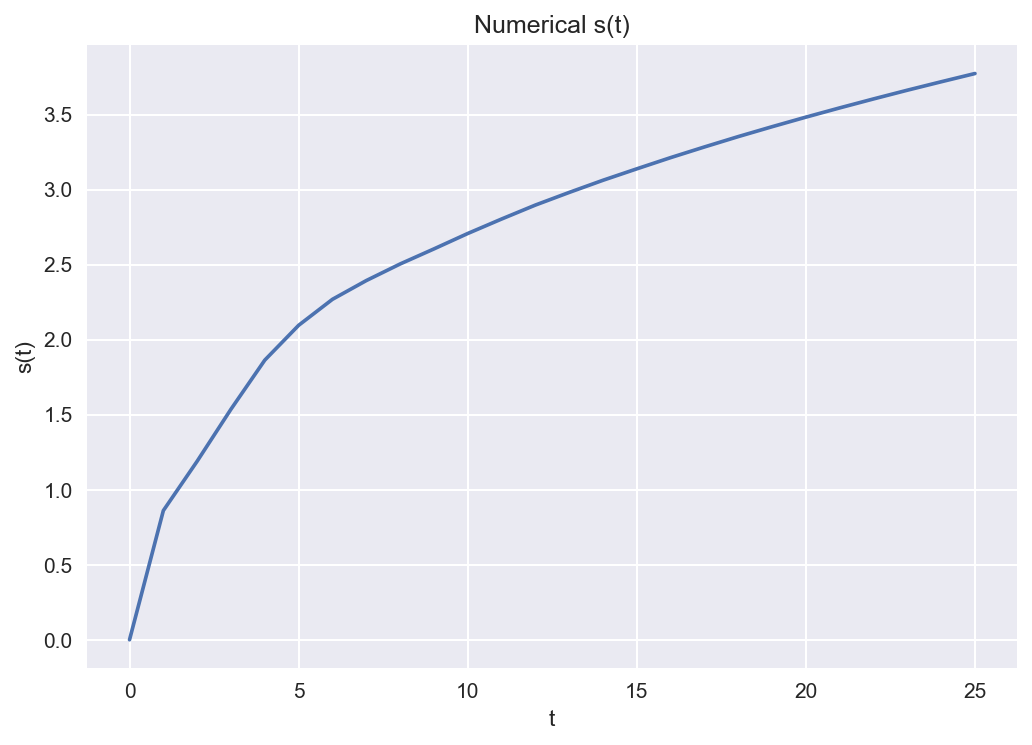

In [71]:
ts = np.arange(0, t+dt, 1)*dt
plt.plot(ts, fdm3[1])
plt.title("Numerical s(t)")
plt.xlabel("t")
plt.ylabel('s(t)')
plt.show()

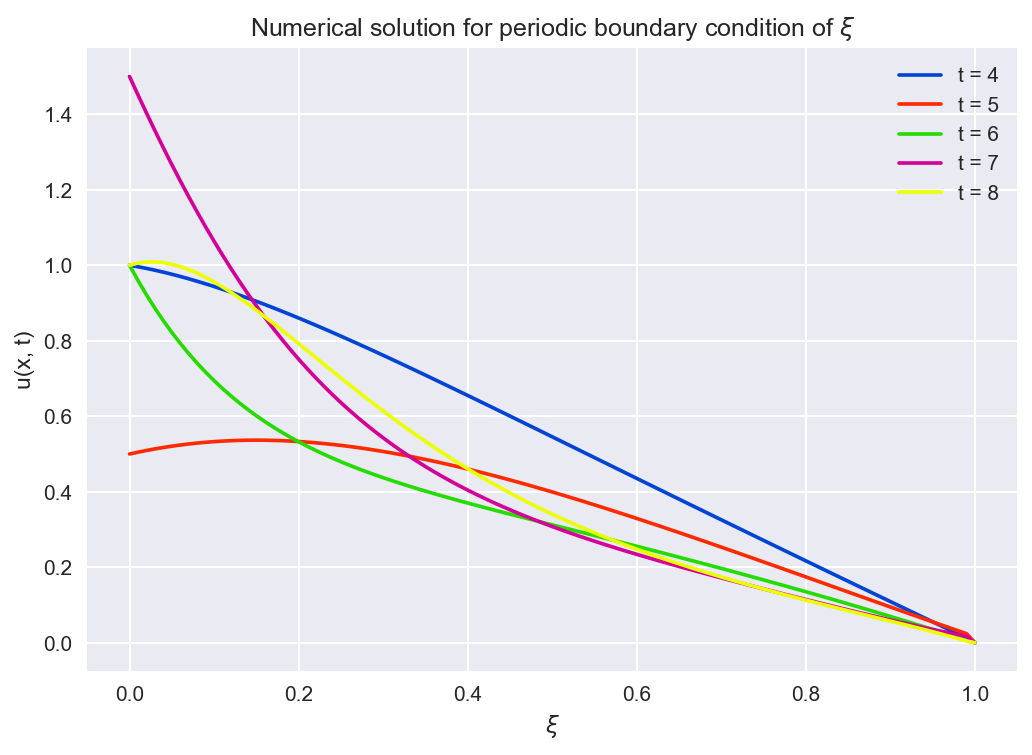

In [72]:
ksi3 = np.linspace(0, 1, M1 + 1)
ts = np.arange(0, t+dt, 1)*dt
colors = plt.cm.prism(np.linspace(0, 1, len(ts))) 
for i in range(4, 9):
    plt.plot(ksi3, fdm3[0][i], c=colors[i], label=f"t = {ts[i]}")
plt.title(r"Numerical solution for periodic boundary condition of $\xi$")
plt.xlabel(r"$\xi$")
plt.ylabel("u(x, t)")
plt.legend()
plt.show()

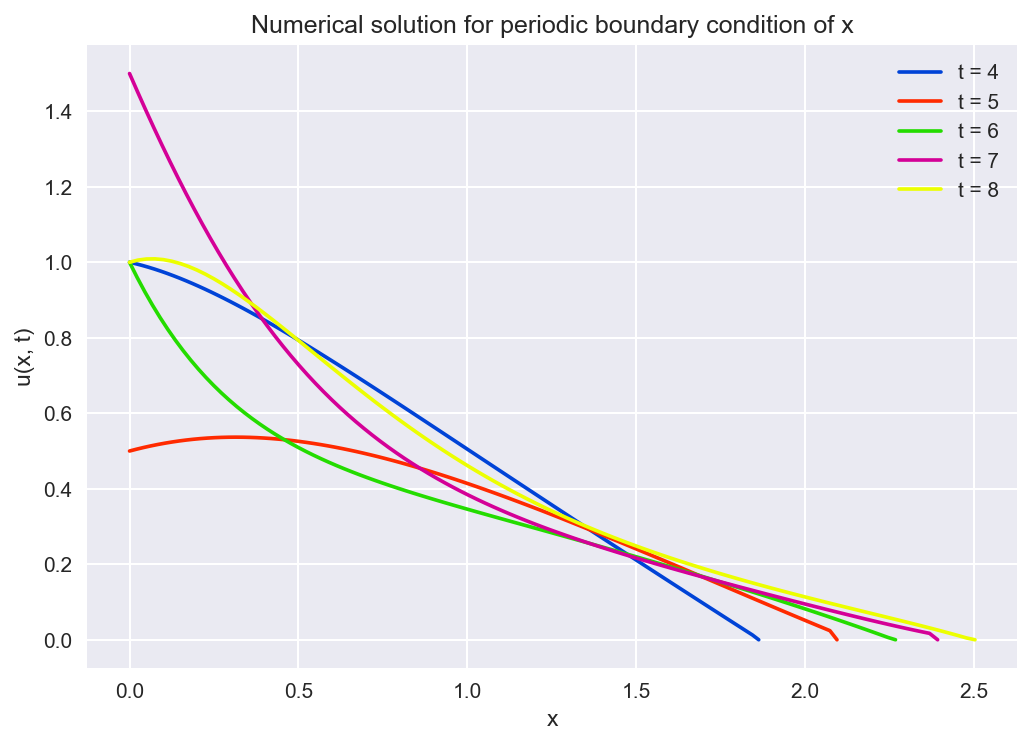

In [73]:
ksi3 = np.linspace(0, 1, M1 + 1)
for i in range(4, 9):
    plt.plot(ksi3*fdm3[1][i], fdm3[0][i], c=colors[i], label=f"t = {ts[i]}")
plt.title(r"Numerical solution for periodic boundary condition of x")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.legend()
plt.show()

### $\beta = 0.5$

In [74]:
t = 25
dt = 1
beta = 0.5
M1 = 100
M2 = 10

In [75]:
fdm4 = finite_difference_method3(t, dt, beta, M1)

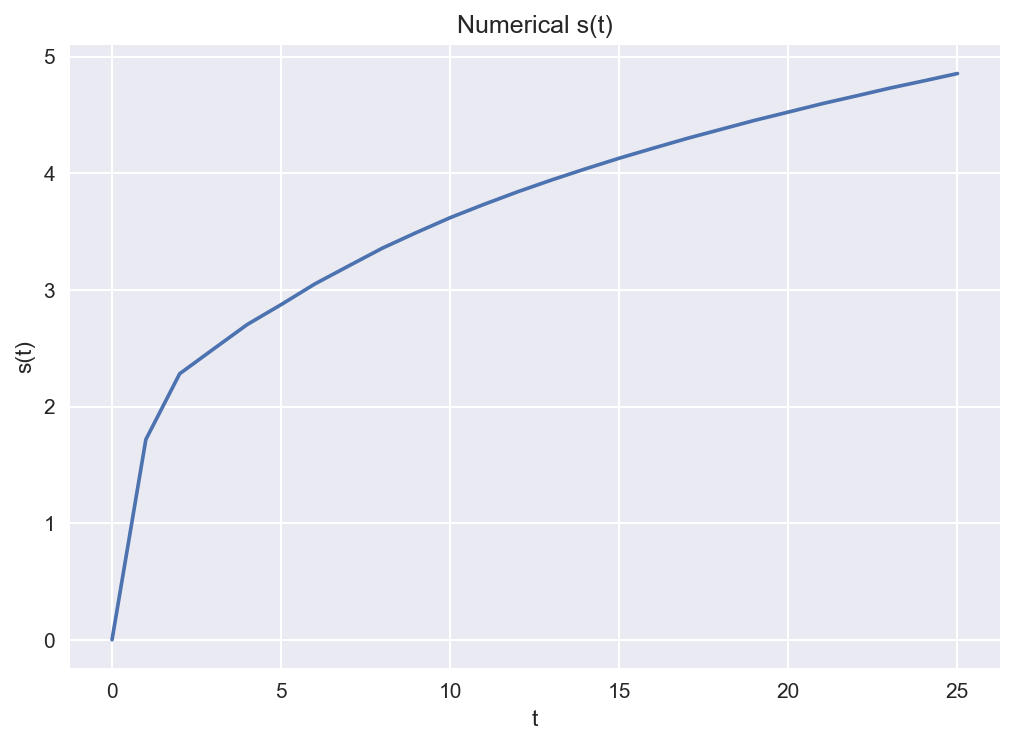

In [76]:
ts = np.arange(0, t+dt, 1)*dt
plt.plot(ts, fdm4[1])
plt.title("Numerical s(t)")
plt.xlabel("t")
plt.ylabel('s(t)')
plt.show()

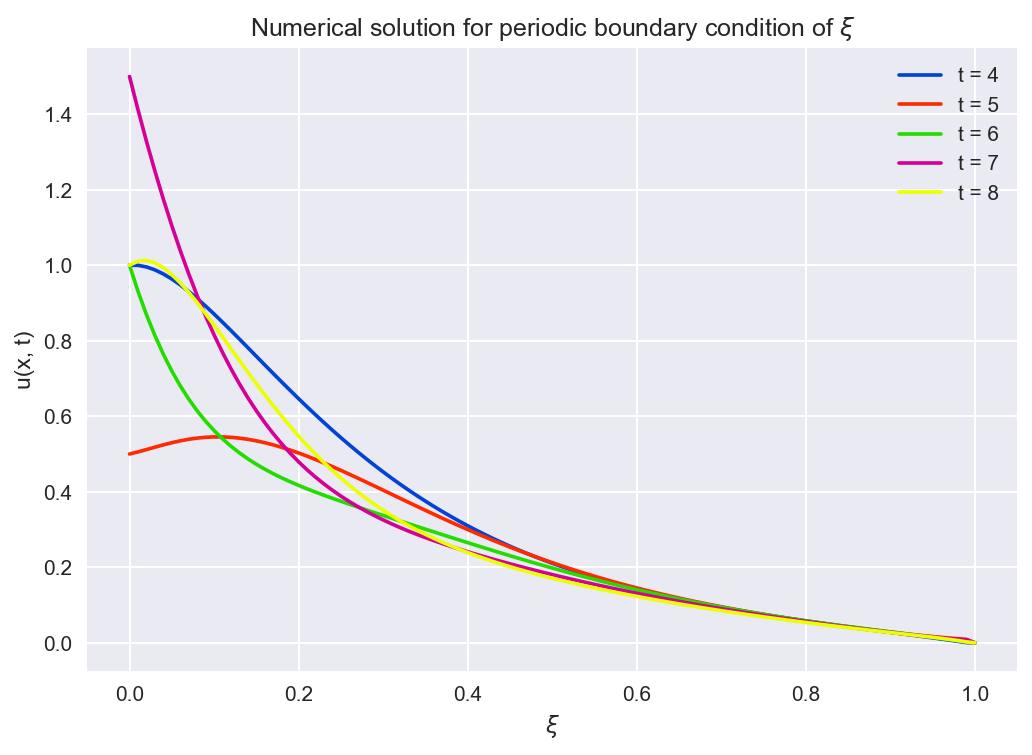

In [77]:
ksi3 = np.linspace(0, 1, M1 + 1)
for i in range(4, 9):
    plt.plot(ksi3, fdm4[0][i], c=colors[i], label=f"t = {ts[i]}")
plt.title(r"Numerical solution for periodic boundary condition of $\xi$")
plt.xlabel(r"$\xi$")
plt.ylabel("u(x, t)")
plt.legend()
plt.show()

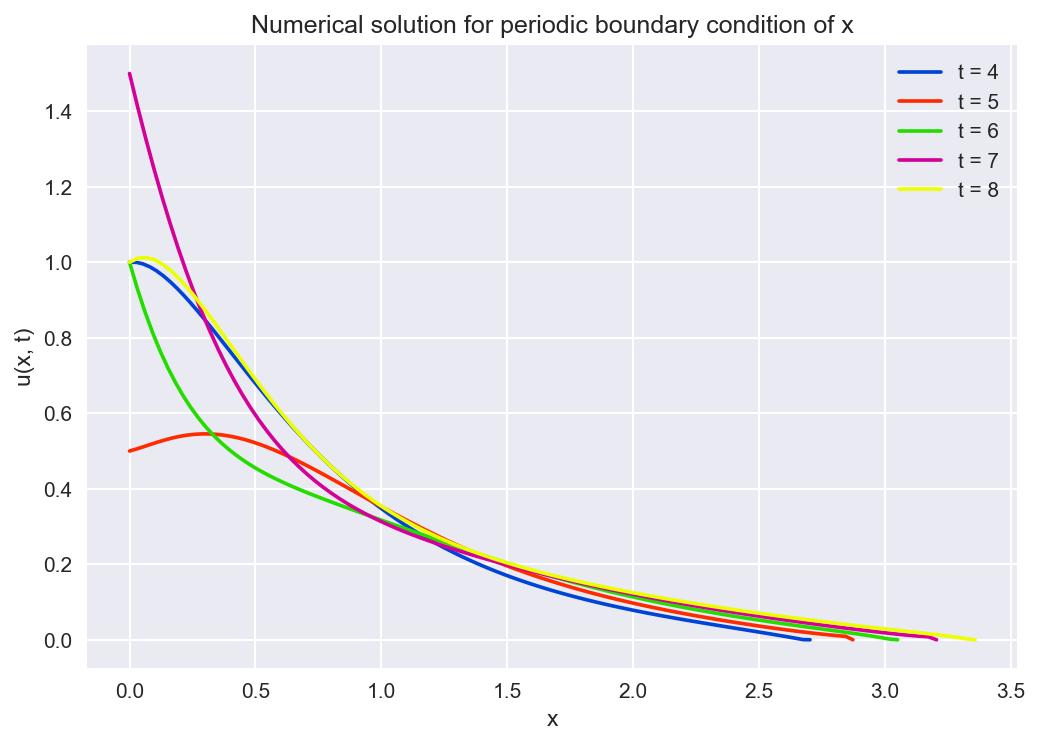

In [78]:
ksi3 = np.linspace(0, 1, M1 + 1)
for i in range(4, 9):
    plt.plot(ksi3*fdm4[1][i], fdm4[0][i], c=colors[i], label=f"t = {ts[i]}")
plt.title(r"Numerical solution for periodic boundary condition of x")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.legend()
plt.show()

### Order of accuracy for constant boudary condition

### For $d\xi$

In [25]:
def error_dx(dt, beta, M):
    l = []
    t_max = 10
    analytical = ana_soli(t_max, dt, beta, M[0])[0][-1]
    for i in range(len(M)):
        numerical = finite_difference_method(t_max, dt, beta, M[i])[0][-1]
        res = [np.sqrt((1/M[i])*(analytical[j] - numerical[2**i * j])**2) for j in range(len(analytical))]
        nres = np.vstack(res)
        l.append(np.sum(nres))
    return l

In [26]:
M = [10*2**i for i in range(8)]
dt = 0.1
beta = 1

In [27]:
dx_error = error_dx(dt, beta, M)

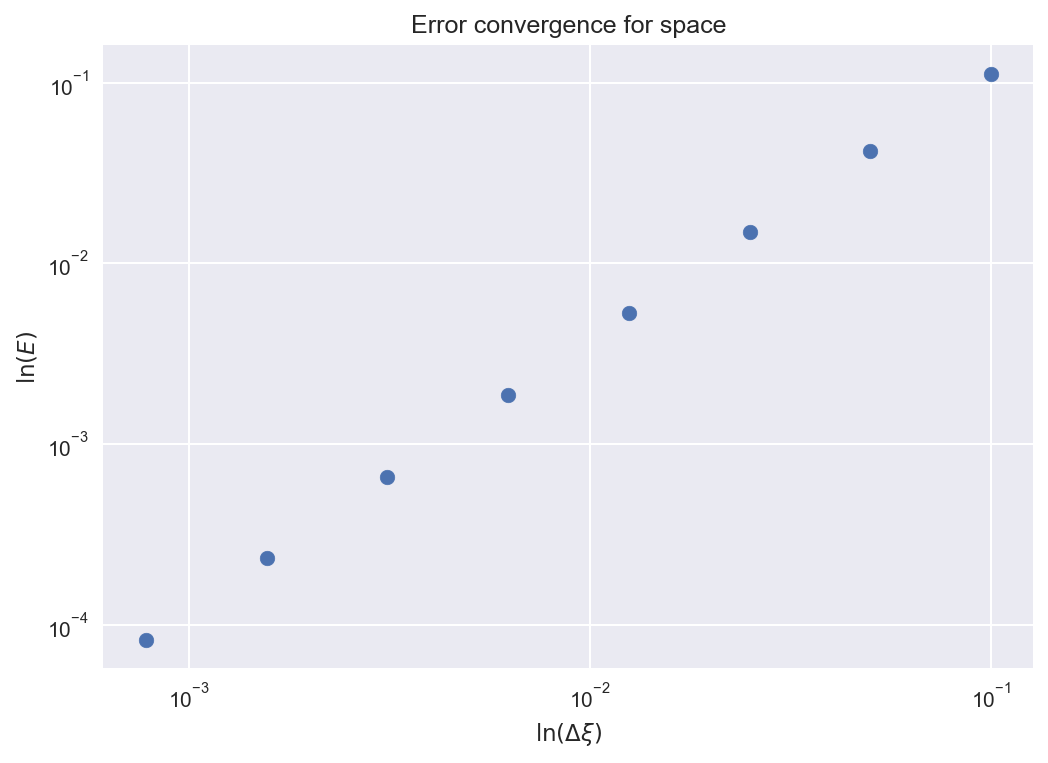

In [31]:
plt.scatter(1/np.array(M), dx_error)
plt.yscale("log")
plt.xscale("log")
plt.title("Error convergence for space")
plt.xlabel(r"$\ln(\Delta \xi)$")
plt.ylabel(r"$\ln(E)$")
plt.show()

In [14]:
p = [np.log(dx_error[i - 1]/dx_error[i])/np.log(2) for i in range(1, len(dx_error))]
p

[1.4329980155667459,
 1.4791088208038126,
 1.496055079282919,
 1.5002312128372224,
 1.5007496061804764,
 1.5005446899447263,
 1.500314830376706]

In [15]:
z = np.polyfit(np.log(1/np.array(M[1:])), np.log(dx_error[1:]), 1)
z

array([1.49739838, 1.31611549])

### For $dt$

In [16]:
def error_dt(dts, beta, M):
    l = []
    analytical = [ana_soli(10, 1/10, beta, M)[0][k][int(M/2)] for k in range(10)]
    for i in range(len(dts)):
        t = dts[i]
        numerical = finite_difference_method(t, 1/t, beta, M)[0][:, int(M/2)]
        res = [np.sqrt((1/dts[i])*(analytical[j] - numerical[2**i * j])**2) for j in range(len(analytical))]
        nres = np.vstack(res)
        l.append(np.sum(nres))
    return l

In [17]:
M = 10
dts = [10*2**i for i in range(8)]
beta = 1

In [18]:
dt_error = error_dt(dts, beta, M)

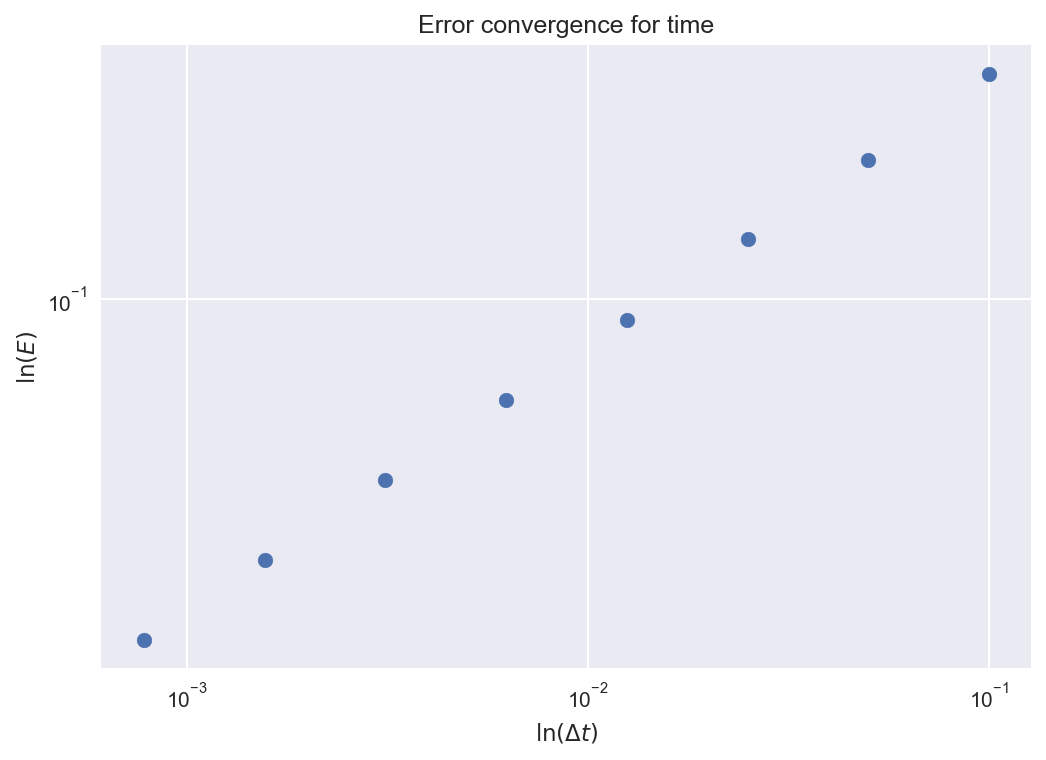

In [30]:
plt.scatter(1/np.array(dts), dt_error)
plt.yscale("log")
plt.xscale("log")
plt.title("Error convergence for time")
plt.xlabel(r"$\ln(\Delta t)$")
plt.ylabel(r"$\ln(E)$")
plt.show()

In [20]:
p = [np.log(dt_error[i - 1]/dt_error[i])/np.log(2) for i in range(1, len(dt_error))]
p

[0.5426596397571577,
 0.4883220129362502,
 0.5060194272153387,
 0.4990845907126916,
 0.5000718698248116,
 0.49999979818017654,
 0.4999999807271976]

In [21]:
z = np.polyfit(np.log(1/np.array(dts)), np.log(dt_error), 1)
z

array([ 0.50280002, -0.18383197])

According to [[5](#bibliography)], the Crank-Nicholson scheme is second-order accurate in both space and time. Although for space convergence our result comes pretty close, for time it is far too low. Our suspection is that the discrepancies may be caused by insufficient accuracy in calculating $s(t)$, which influences the final result very much. It might be that the Newton-Raphson method we used for $s(t)$ is not accurate enough in this case.

### Bibliography

<a id="bibliography"></a>
[1] https://www.sciencedirect.com/science/article/pii/S0096300309006638 <br>
[2] https://www.diva-portal.org/smash/get/diva2:647481/FULLTEXT01.pdf <br>
[3] https://ceramrtr.ceramika.agh.edu.pl/~szyszkin/tmp/tmp3/Modelling%20and%20Simulation%20of%20Ice-Snow%20Melting.pdf <br>
[4] https://www.sciencedirect.com/science/article/pii/S0017931003000504 <br>
[5] https://www.sfu.ca/~rjones/bus864/notes/notes2.pdf <br>
[6] https://personal.math.ubc.ca/~anstee/math104/newtonmethod.pdf <br>
[7] https://www.sfu.ca/~rjones/bus864/notes/notes2.pdf

#### s like surface, h like height and we are flying